<a href="https://colab.research.google.com/github/Nazhan99/Tensorflow_notes/blob/main/08_Intro_to_NLP_in_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sdequences text or speech)

Another common term for NLP problems is sequence to sequence problems (seq2seq)

##Check for GPU


In [1]:
!nvidia-smi

Tue Mar  8 05:56:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

#import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves , compare_historys

--2022-03-08 05:56:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-03-08 05:56:40 (86.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset

The data set we are going to be using is Kaggle's introduction to NLP dataset (text samples of tweets labelled as disaster or not disaster)

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

#unzip data
unzip_data("nlp_getting_started.zip")

--2022-03-08 05:56:43--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 142.250.157.128, 142.251.8.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2022-03-08 05:56:44 (92.4 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualize a text dataset

In [4]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train_df["text"][1]

'Forest fire near La Ronge Sask. Canada'

In [7]:
#shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [8]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
#how many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [10]:
#how many total samples?
len(train_df)

7613

In [11]:
len(test_df)

3263

In [12]:
#let's visualize some random training examples
import random 
random_index= random.randint(0,len(train_df)-5) #create random indexes not higeher than total samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n {text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
 Visting Georgina at The Drowned Rat Cafe.....awful view!! http://t.co/pYLFb3tI9U

---

Target: 1 (real disaster)
Text:
 My prediction for the Vikings game this Sunday....dont expect a whole lot. Infact I think Zimmer goal is....injury free 1st game

---

Target: 0 (not real disaster)
Text:
 #dating #meet #sex Hot Teen Ass Exploded By Fat Cock http://t.co/X39JwSyrqR

---

Target: 1 (real disaster)
Text:
 Bicycle-SUV accident in Mesick: Police say that the bicyclist entered onto West M-115 and collided with a boat... http://t.co/A9gtOPyZK8

---

Target: 1 (real disaster)
Text:
 Back from Seattle Tacoma and Portland. Whirlwind! http://t.co/qwHINBni8e

---



### Split data into training and validation sets

In [13]:
from sklearn.model_selection import train_test_split


In [14]:
#use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                            train_df_shuffled["target"].to_numpy(),
                                            test_size=0.1, #use 10% of training data for validation
                                            random_state=42)

In [15]:
#check the lengths
len(train_sentences) , len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [16]:
#check the first 10 samples 
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

When dealing with  a text problem, one of the first things you will have to do before you can build a model is to conver tthe text to numbers.

There are a few way to do:

* Tokenization - direct mapping of token( a token could be a word or a character) to number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

## Text vectorization (tokenization)

In [17]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [18]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

#https://tensorflow.google.cn/api_docs/python/tf/keras/layers/TextVectorization

In [19]:
#Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=50,# how many words in the vocabulary (automatically add <OOV>)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, #create groups of n-words?
                                    output_mode="int" ,#how to map tokens to numbers
                                    output_sequence_length=None, #how long do you want your sequences to be
                                    pad_to_max_tokens=True)

In [20]:
#find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [21]:
#setup text vectorization variables
max_vocab_length = 10000 #max number of words to have in our vocabualry
max_length= 15 #max length our sequences will be ( how many words from a tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                     output_mode="int",
                                     output_sequence_length=max_length)

In [22]:
#fit the text vectorizer 
text_vectorizer.adapt(train_sentences)

In [23]:
#create a sample sentence and tokenize it 
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [24]:
#Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 thinking of the time that my friend bailed the nite b4 a dead show...went alone &amp; had a GREAT time. All alone and free to dance. Front row        

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 982,    6,    2,   92,   16,   13, 1020,    1,    2,    1, 2552,
           3,  115, 8537,  910]])>

In [25]:
#get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all the unique word 
top_5_words = words_in_vocab[:5] #get the most common words
bottom_5_words = words_in_vocab[:-5] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {len(top_5_words)}, {top_5_words}")
print(f"5 least common words: {len(bottom_5_words)}, {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: 5, ['', '[UNK]', 'the', 'a', 'in']
5 least common words: 9995, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is', 'for', 'on', 'you', 'my', 'with', 'it', 'that', 'at', 'by', 'this', 'from', 'be', 'are', 'was', 'have', 'like', 'as', 'up', 'so', 'just', 'but', 'me', 'im', 'your', 'not', 'amp', 'out', 'its', 'will', 'an', 'no', 'has', 'fire', 'after', 'all', 'when', 'we', 'if', 'now', 'via', 'new', 'more', 'get', 'or', 'about', 'what', 'he', 'people', 'news', 'been', 'over', 'one', 'how', 'dont', 'they', 'who', 'into', 'were', 'do', 'us', '2', 'can', 'video', 'emergency', 'there', 'disaster', 'than', 'police', 'would', 'his', 'still', 'her', 'some', 'body', 'storm', 'crash', 'burning', 'suicide', 'back', 'man', 'california', 'why', 'time', 'them', 'had', 'buildings', 'rt', 'first', 'cant', 'see', 'got', 'day', 'off', 'our', 'going', 'nuclear', 'know', 'world', 'bomb', 'fires', 'love', 'killed', 'go', 'attack', 'youtube', 'dea

## Creating an embedding using a Embedding Layer

To make our embedding, we are going to use tensorflow embedding layer

refer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would be 100 long,
* `input_length` = length of the sequences being passed to the embedding layer

In [26]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, #set input shape
                             embeddings_initializer= "uniform",
                             output_dim=128,
                             input_length=max_length #how long is each input
                             )

embedding

In [27]:
#get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
      \n\nEmbedded version:")

#embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 @bbclaurak Why is no one talking about the risk of a suicide bomber hiding amongst the migrants stowing aboard the Eurotunnel  trains?      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04533316, -0.02193194,  0.04095575, ...,  0.03957108,
         -0.03956436,  0.04284442],
        [-0.0142195 ,  0.04485858, -0.02098867, ..., -0.00457721,
         -0.01469418, -0.04548469],
        [-0.00711731, -0.0494994 , -0.04529679, ..., -0.04841784,
         -0.02925052,  0.03612366],
        ...,
        [-0.02158242,  0.00670996,  0.01234045, ..., -0.02134272,
         -0.03796155,  0.02093479],
        [ 0.0094822 , -0.0462948 , -0.00990639, ..., -0.02654727,
         -0.01401123,  0.03950817],
        [ 0.04595898,  0.00744643,  0.03823609, ...,  0.01242663,
         -0.04680653, -0.00639379]]], dtype=float32)>

In [28]:
#check out a singel token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 4.53331582e-02, -2.19319351e-02,  4.09557484e-02, -3.25521007e-02,
        -1.67892203e-02, -2.03222875e-02, -4.30065989e-02, -3.19874771e-02,
        -8.77072662e-03,  2.70310305e-02, -2.60538980e-03,  1.80945136e-02,
         8.88627768e-03,  5.53615019e-03, -1.59106739e-02, -4.14322838e-02,
        -1.86921246e-02,  1.10558160e-02, -1.02008805e-02,  1.44057311e-02,
        -5.42992353e-03,  2.02295668e-02, -1.37920864e-02, -2.02108547e-03,
         3.97080891e-02, -3.01017612e-03,  2.29731314e-02,  3.45127694e-02,
        -4.98564243e-02,  3.29906605e-02, -2.44665276e-02, -3.78994830e-02,
        -2.49964129e-02,  3.11294310e-02, -4.62121256e-02, -3.70243937e-03,
        -4.86317389e-02, -3.42474580e-02, -3.66326943e-02, -2.75998954e-02,
        -2.31600758e-02,  9.70711559e-03, -4.47197445e-02, -4.09242623e-02,
        -8.63413885e-03, -2.87842993e-02, -1.26929395e-02, -3.74382846e-02,
        -1.27487667e-02, -4.99948636e-0

## Modelling a text dataset (running a series of experiments)

Now we have got way to turn our text sequences into numbers, it is time to start building a series of modelling experiments.

We will start with a baseline and move on from there.

* Model 0: Naive Bayes(baseline, this is from sklearn ML map: 
* Model 1: Feed=forward Neural Network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: Tensorflow Hub pretrained feature extractor (using transfer learning for NLP)
* Model 7: same as model 6 with 10% of training data

how are we going to approach all of these?

Use the standard steps in modelling with tensorflow:
* Create a model
* Build a model
* Fit a model
* Evaluate our model

## Model 0: Getting a baseline

As with all machine learning modelling experiments, it is important to create a baseline model so you have got a benchmark for future experiments to build upon.

To create our baseline, we will use Sklearn's Multinormial Naive Bayes using the T-IDF ormula to convert our words to numbers.

>Note: It's common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), #convert words to numebers using tfidf
                    ("clf", MultinomialNB()) #model the text, "clf" stands for classifier

])

#Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels )

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [30]:
#Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [31]:
#make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation functions for our model experiments

We could evaluate all of our model's predictions with different metrics every time,  however this will be cumbersome and could easily fix with a function.

Let's create one to compare our model's predicitons with the truth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1-score

For a deep overview of many different evalaution methods, see the Sklearn documentation: https://scikit-learn.org/stable/model_selection.html

In [32]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculate model accuracy, precision, recall and 1-core of a binary classification model
  """

  #calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)*100

  #calculate model precision, recall and 1-score using "weighted" average
  model_precision, model_recall, model_f1, _ =precision_recall_fscore_support(y_true,y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results


In [33]:
#get baseline results
baseline_results = calculate_results(y_true= val_labels, 
                                     y_pred= baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Model 1: A simple dense model



In [34]:
#create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

#create a directory to save TensorBoard logs
SAVE_DIR ="model_logs"

In [35]:
#build model with the Funtional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) #inputs are 1-dimensional strings
x =text_vectorizer(inputs) #turn the input text into numbers
x =embedding(x) #create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(1, activation="sigmoid")(x) #create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [36]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_avg_pool_layer (Glob  (None, 128)              0         
 alAveragePooling1D)                                             
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [37]:
#compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
  

In [38]:
#fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20220308-055649
Epoch 1/5
215/215 [==============================] - 5s 8ms/step - loss: 0.6138 - accuracy: 0.6866 - val_loss: 0.5368 - val_accuracy: 0.7520
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.4429 - accuracy: 0.8200 - val_loss: 0.4711 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3476 - accuracy: 0.8597 - val_loss: 0.4643 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2861 - accuracy: 0.8886 - val_loss: 0.4718 - val_accuracy: 0.7940
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2393 - accuracy: 0.9111 - val_loss: 0.4789 - val_accuracy: 0.7900


In [39]:
#check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4789 - accuracy: 0.7900


[0.47888147830963135, 0.7900262475013733]

In [40]:
#make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

(762, 1)

In [41]:
model_1_pred_probs[:10]

array([[0.36685944],
       [0.80765957],
       [0.997488  ],
       [0.09978938],
       [0.09857418],
       [0.936077  ],
       [0.91902566],
       [0.99334586],
       [0.96792865],
       [0.21231052]], dtype=float32)

In [42]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_avg_pool_layer (Glob  (None, 128)              0         
 alAveragePooling1D)                                             
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [43]:
#convert  model predictions probs to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))

In [44]:
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [45]:
#calculate our model_1_results
model_1_results = calculate_results(y_true = val_labels,
                                    y_pred=model_1_preds)

In [46]:
model_1_results

{'accuracy': 79.00262467191601,
 'f1': 0.7870730838048355,
 'precision': 0.795059849830577,
 'recall': 0.7900262467191601}

In [47]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [48]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False,  True])

## Visualizing learned embeddings

In [49]:
# get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [50]:
#model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_avg_pool_layer (Glob  (None, 128)              0         
 alAveragePooling1D)                                             
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [51]:
# get the weight matrix of embeding layer
#get the numerical representations of each token in our trianing data
embed_weights= model_1.get_layer("embedding").get_weights()[0]
embed_weights

array([[-0.03694197,  0.06514872,  0.00505028, ...,  0.04631976,
         0.01249111,  0.00855055],
       [ 0.04591632, -0.01457794,  0.04916414, ...,  0.04811877,
        -0.04576415,  0.0358984 ],
       [ 0.04343884, -0.02795736,  0.02299051, ...,  0.01140994,
         0.01184726,  0.01355479],
       ...,
       [-0.03556386,  0.04362291, -0.00211449, ..., -0.01488894,
         0.03978547,  0.02287242],
       [ 0.04107061,  0.02361586, -0.01105272, ...,  0.04346991,
        -0.02300452, -0.08758093],
       [ 0.1006726 ,  0.03492181,  0.02441406, ...,  0.0615473 ,
        -0.06275145, -0.1099739 ]], dtype=float32)

In [52]:
print(embed_weights.shape) #same size as vocab size and embedding dim (output dim of our embedding layer)

(10000, 128)


Now we have got the embedding matrix our model has learned to represent our tokens, lets see how we can visualize it. 

To do so, TensorFlow has a handy tool called projector :http://projector.tensorflow.org/

And tensorflow also has a incredible guide on word embeddings themselves: https://www.tensorflow.org/text/guide/word_embeddings

In [53]:
# #create embedding files (we got this from tensorflwo word embeddings documentation)
# import io
# out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
# out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

# for index, word in enumerate(words_in_vocab):
#   if index == 0:
#     continue  # skip 0, it's padding.
#   vec = embed_weights[index]
#   out_v.write('\t'.join([str(x) for x in vec]) + "\n")
#   out_m.write(word + "\n")
# out_v.close()
# out_m.close()

In [54]:
# #download files from colab to projector (http://projector.tensorflow.org/)
# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

Downloading the files above we can visualize them using http://projector.tensorflow.org/ and clicking the "load" button on the left hand same

>Resouces: If you would like to know more about embeddings. I would encourage you to check out:
* https://jalammar.github.io/illustrated-word2vec/
* https://www.tensorflow.org/text/guide/word_embeddings

## Recurrent Neural Networks (RNN's)

RNN are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

## Model 2: LSTM

LSTM= long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this: 

```
Input(text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probabilities)
```

In [55]:
#create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#print(x.shape)
#x = layers.LSTM(64, return_sequences=True)(x) #when you are stacking RNN cells together, you need to set return_sequences
#print(x.shape)
x = layers.LSTM(64)(x)
#print(x.shape)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [56]:
# get a summary
model_2.summary()


Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                      

In [57]:
#compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [58]:
#fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20220308-055702
Epoch 1/5
215/215 [==============================] - 7s 13ms/step - loss: 0.2202 - accuracy: 0.9184 - val_loss: 0.6089 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1590 - accuracy: 0.9385 - val_loss: 0.5676 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1267 - accuracy: 0.9523 - val_loss: 0.7011 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1014 - accuracy: 0.9593 - val_loss: 0.8883 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0796 - accuracy: 0.9688 - val_loss: 1.0026 - val_accuracy: 0.7730


In [59]:
#make prediction with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[9.3176505e-03],
       [6.9205779e-01],
       [9.9994886e-01],
       [9.5254980e-02],
       [8.0874495e-05],
       [9.9935383e-01],
       [6.3267046e-01],
       [9.9997342e-01],
       [9.9991858e-01],
       [5.2569354e-01]], dtype=float32)

In [60]:
#convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [61]:
#calculate model 2 results
model_2_results= calculate_results(y_true=val_labels,
                                   y_pred= model_2_preds)

In [62]:
model_2_results

{'accuracy': 77.29658792650919,
 'f1': 0.7707112186521387,
 'precision': 0.7750482481613202,
 'recall': 0.7729658792650919}

In [63]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 3: GRU

Another popular and effective RNN component is the GRU or Gated Recurrent Unit.

The GRU cell has similar features to an LSTM cell but has less parameters

In [64]:
#Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
#x = layers.GRU(64, return_sequences=True)(x) #put return_sequences=True if stacking the recurrent layers
# x = layers.LSTM(64,return_sequences=True)(x)
# x = layers.GRU(64)(x)
# x = layers.Dense(64,activation="relu")(x)

outputs = layers.Dense(1,activation = "sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [65]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [66]:
#compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [67]:
#fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data= (val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20220308-055719
Epoch 1/5
215/215 [==============================] - 7s 18ms/step - loss: 0.1505 - accuracy: 0.9397 - val_loss: 0.8074 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0861 - accuracy: 0.9701 - val_loss: 0.8045 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0718 - accuracy: 0.9721 - val_loss: 0.8857 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0613 - accuracy: 0.9743 - val_loss: 1.1059 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0519 - accuracy: 0.9781 - val_loss: 1.2484 - val_accuracy: 0.7664


In [68]:
#make prediction with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[3.6902190e-03],
       [8.1099808e-01],
       [9.9992549e-01],
       [3.7586723e-02],
       [8.7056149e-05],
       [9.9970102e-01],
       [9.4920748e-01],
       [9.9995601e-01],
       [9.9991870e-01],
       [9.7144914e-01]], dtype=float32)

In [69]:
#convert model 3 pred probs to labels
model_3_preds= tf.squeeze(tf.round(model_3_pred_probs))

In [70]:
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [71]:
#calculate model 3 result
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred =model_3_preds)

model_3_results

{'accuracy': 76.64041994750657,
 'f1': 0.7642857598265804,
 'precision': 0.7679094748917975,
 'recall': 0.7664041994750657}

## Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you would read an english snetences), however bidirectional RNN goes from right to left as well as left to right.

Refer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional

In [72]:
#Build a biirectional RNN in tensorflow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
# x = layers.Bidirectional(layers.GRU(64))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [73]:
#get summary 
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [74]:
#compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [75]:
#fit the model
model_4_history=model_4.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences, val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20220308-055743
Epoch 1/5
215/215 [==============================] - 8s 19ms/step - loss: 0.1088 - accuracy: 0.9663 - val_loss: 0.9088 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0542 - accuracy: 0.9775 - val_loss: 1.1782 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0442 - accuracy: 0.9801 - val_loss: 1.3264 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0416 - accuracy: 0.9800 - val_loss: 1.5716 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0442 - accuracy: 0.9788 - val_loss: 1.3616 - val_accuracy: 0.7730


In [76]:
#make prediction
model_4_pred_probs=model_4.predict(val_sentences)

In [77]:
model_4_pred_probs[:10]

array([[4.1344014e-01],
       [6.1604828e-01],
       [9.9992704e-01],
       [1.7170897e-01],
       [1.6864320e-05],
       [9.9974948e-01],
       [8.9878756e-01],
       [9.9996781e-01],
       [9.9994349e-01],
       [9.9720913e-01]], dtype=float32)

In [78]:
#convert pred probs to pred labels
model_4_preds= tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [79]:
#calcualte the results of our bidirectional model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)

In [80]:
model_4_results

{'accuracy': 77.29658792650919,
 'f1': 0.77144803030122,
 'precision': 0.77365375135567,
 'recall': 0.7729658792650919}

## Convolutional Neural Network for text (and other types of sequences)

we have used CNNs for images are typically 2D (height x width).. however, our text data is 1D.

Conv2D we ahve Conv2D for our image data but now we are gooing to use Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text):
```
Inputs (text)-> Tokenization -> Embedding -> Layer(s) -> (typically Conv1D +pooling) -> Outputs (class probabilities)
```

### Model 5: Conv1D

refer: https://poloclub.github.io/cnn-explainer/

In [81]:
#Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) #turn target sentence into embedding
conv_1d= layers.Conv1D(filters=32,
                       kernel_size=5, #this is also referred to as an ngram of 5
                       strides=1, #default
                       activation="relu",
                       padding="valid") #default="valid", the output is smaller than input

conv_1d_output = conv_1d(embedding_test) #pas test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output=max_pool(conv_1d_output) #equivalent to "get the most importnat feature" or get the highest value

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [82]:
#create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype= tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)

#x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

#compile the Conv1D
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#get a summary of our Conv1D model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 1)              

In [83]:
# fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data = (val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20220308-055814
Epoch 1/5
215/215 [==============================] - 3s 8ms/step - loss: 0.1242 - accuracy: 0.9635 - val_loss: 0.8927 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0746 - accuracy: 0.9742 - val_loss: 1.0771 - val_accuracy: 0.7612
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0605 - accuracy: 0.9766 - val_loss: 1.1815 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0541 - accuracy: 0.9780 - val_loss: 1.1783 - val_accuracy: 0.7598
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0518 - accuracy: 0.9791 - val_loss: 1.1691 - val_accuracy: 0.7572


In [84]:
#make some predictions with our Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[1.3902621e-01],
       [8.9584744e-01],
       [9.9977094e-01],
       [6.9093615e-02],
       [2.3529547e-07],
       [9.9938869e-01],
       [9.9223691e-01],
       [9.9998271e-01],
       [9.9999917e-01],
       [9.3331033e-01]], dtype=float32)

In [85]:
#convert model_5 to labels
model_5_preds= tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [86]:
#evaluate model 5 predictions
model_5_results = calculate_results(y_true = val_labels,
                                    y_pred = model_5_preds)

model_5_results

{'accuracy': 75.7217847769029,
 'f1': 0.7563501070538545,
 'precision': 0.7568784468743027,
 'recall': 0.7572178477690289}

NLP dataset resources: https://huggingface.co/models

## Model 6: TensoorFlow Hub Pretrained Sentence Encoder

Now we have built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlwo Hub's universal sentence encoder: https://tfhub.dev/google/universal-sentence-encoder/4

see how USE was created here: https://arxiv.org/abs/1803.11175v2

In [87]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When you call the universal sentence encoder on a sentece, it turns it into numbers"])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157024  0.0248591   0.0287805  -0.01271502  0.03971543  0.08827759
  0.02680986  0.05589837 -0.01068731 -0.0059729   0.00639324 -0.01819523
  0.00030817  0.09105891  0.05874644 -0.03180627  0.01512476 -0.05162928
  0.00991369 -0.06865346 -0.04209306  0.0267898   0.03011008  0.00321069
 -0.00337969 -0.04787359  0.02266718 -0.00985924 -0.04063614 -0.01292095
 -0.04666384  0.056303   -0.03949255  0.00517685  0.02495828 -0.07014439
  0.02871508  0.04947682 -0.00633971 -0.08960191  0.02807117 -0.00808362
 -0.01360601  0.05998649 -0.10361786 -0.05195372  0.00232955 -0.02332528
 -0.03758105  0.0332773 ], shape=(50,), dtype=float32)


In [88]:
embed_samples[0].shape

TensorShape([512])

In [89]:
#create keras layer using USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype = tf.string,
                                        trainable=False,
                                        name="USE")

In [90]:
#create model using the sequential API
model_6 = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64, activation="relu",),
                               layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

#compile
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [91]:
#train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                      "tf_hub_sentences_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentences_encoder/20220308-055853
Epoch 1/5
215/215 [==============================] - 7s 20ms/step - loss: 0.5064 - accuracy: 0.7822 - val_loss: 0.4504 - val_accuracy: 0.7940
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.4155 - accuracy: 0.8152 - val_loss: 0.4377 - val_accuracy: 0.8136
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.4009 - accuracy: 0.8229 - val_loss: 0.4328 - val_accuracy: 0.8097
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3931 - accuracy: 0.8279 - val_loss: 0.4282 - val_accuracy: 0.8084
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.3859 - accuracy: 0.8291 - val_loss: 0.4242 - val_accuracy: 0.8123


In [92]:
#make predictions with USE TF hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.19900356],
       [0.7984542 ],
       [0.98992634],
       [0.24875173],
       [0.72114086],
       [0.76638687],
       [0.9821035 ],
       [0.9784781 ],
       [0.95279497],
       [0.12475055]], dtype=float32)

In [93]:
#convert predictions probs to labels
model_6_pred = tf.squeeze(tf.round(model_6_pred_probs))
model_6_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [94]:
#calculate model 6 performance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_pred)

model_6_results

{'accuracy': 81.23359580052494,
 'f1': 0.8115900402999853,
 'precision': 0.8126207816553097,
 'recall': 0.8123359580052494}

In [95]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you dont have a large dataset.

To see how our model performs on a smaller dataset, let's replicate model_6 expect we will train it on 10% of the data.


In [96]:
## Note: making data splits like below leads to data leakage (model_7 trained on 10% data, outperform model_6 trained on 100% data)
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SETS

#create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)

# #train_10_percent.head(), len(train_10_percent)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

> **Note:** Be *very* careful when creating training/val/test splits that you dont leak data across the datasets, otherwise your model evaluation metrics will be wrong. If tsomething looks too good to be true (a model trained 10% of data outperforming the same model trained on 100% of data) trust yoour gut and go back to where the error may lie.

In [97]:
# making a better datasplit (no data leakage)
train_10_percent_split = int(0.1*len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [98]:
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [99]:
#check the number of targets in our subset of data
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [100]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreate a model the same to a previous model you have created you can use the 'tf.keras.models.clone_model()'method, see more here: https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [101]:
#let's build a model the same as model_6
#model_7 = tf.keras.models.clone_model(model_6)

model_7 = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64, activation="relu",),
                               layers.Dense(1, activation="sigmoid")
], name="model_7_USE")

#compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#get a summary (will be same as model_6)
model_7.summary()


Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_8 (Dense)             (None, 64)                32832     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [107]:
#Fit the model to the 10% training subset
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentences_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentences_encoder_10_percent_correct_split/20220308-060015
Epoch 1/5
22/22 [==============================] - 2s 68ms/step - loss: 0.3952 - accuracy: 0.8453 - val_loss: 0.4874 - val_accuracy: 0.7769
Epoch 2/5
22/22 [==============================] - 1s 66ms/step - loss: 0.3740 - accuracy: 0.8526 - val_loss: 0.4875 - val_accuracy: 0.7782
Epoch 3/5
22/22 [==============================] - 1s 60ms/step - loss: 0.3556 - accuracy: 0.8584 - val_loss: 0.4890 - val_accuracy: 0.7795
Epoch 4/5
22/22 [==============================] - 1s 60ms/step - loss: 0.3403 - accuracy: 0.8628 - val_loss: 0.4920 - val_accuracy: 0.7769
Epoch 5/5
22/22 [==============================] - 1s 37ms/step - loss: 0.3286 - accuracy: 0.8672 - val_loss: 0.4992 - val_accuracy: 0.7730


In [108]:
#make predictions with the model trained on 10% of the data
model_7_pred_probs= model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.06912575],
       [0.5455342 ],
       [0.96807903],
       [0.36990383],
       [0.5647766 ],
       [0.614213  ],
       [0.95405406],
       [0.8876598 ],
       [0.92255723],
       [0.1106066 ]], dtype=float32)

In [109]:
#turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [110]:
#evaluate model 7 predictions
model_7_results = calculate_results(y_true = val_labels,
                                    y_pred = model_7_preds)

model_7_results

{'accuracy': 77.29658792650919,
 'f1': 0.7716665369372698,
 'precision': 0.7733211200948874,
 'recall': 0.7729658792650919}

In [111]:
model_6_results

{'accuracy': 81.23359580052494,
 'f1': 0.8115900402999853,
 'precision': 0.8126207816553097,
 'recall': 0.8123359580052494}

## Comparing the performance of each of our models

In [124]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_LSTM": model_2_results,
                                  "3_GRU": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_Conv1D": model_5_results,
                                  "6_tf_hub_USE_encoder": model_6_results,
                                  "7_tf_hub_USE_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,79.002625,0.795060,0.790026,0.787073
2_LSTM,77.296588,0.775048,0.772966,0.770711
3_GRU,76.640420,0.767909,0.766404,0.764286
4_bidirectional,77.296588,0.773654,0.772966,0.771448
5_Conv1D,75.721785,0.756878,0.757218,0.756350
6_tf_hub_USE_encoder,81.233596,0.812621,0.812336,0.811590
7_tf_hub_USE_encoder_10_percent,77.296588,0.773321,0.772966,0.771667


In [126]:
#reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.790026,0.795060,0.790026,0.787073
2_LSTM,0.772966,0.775048,0.772966,0.770711
3_GRU,0.766404,0.767909,0.766404,0.764286
4_bidirectional,0.772966,0.773654,0.772966,0.771448
5_Conv1D,0.757218,0.756878,0.757218,0.756350
6_tf_hub_USE_encoder,0.812336,0.812621,0.812336,0.811590
7_tf_hub_USE_encoder_10_percent,0.772966,0.773321,0.772966,0.771667


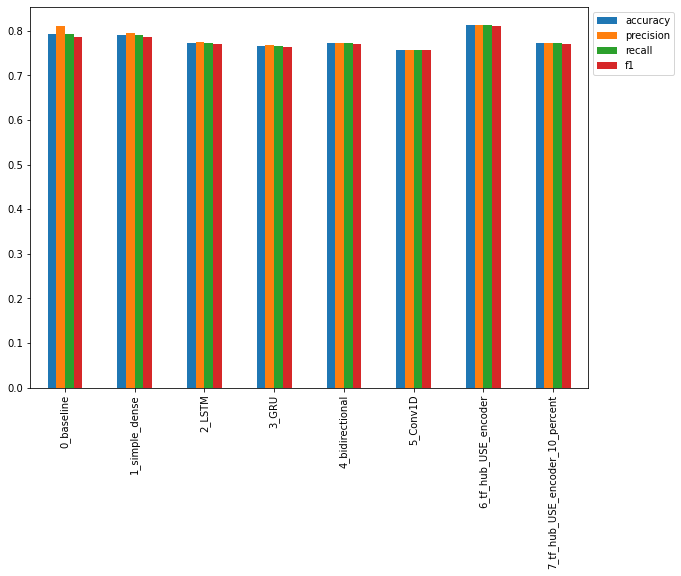

In [127]:
#plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

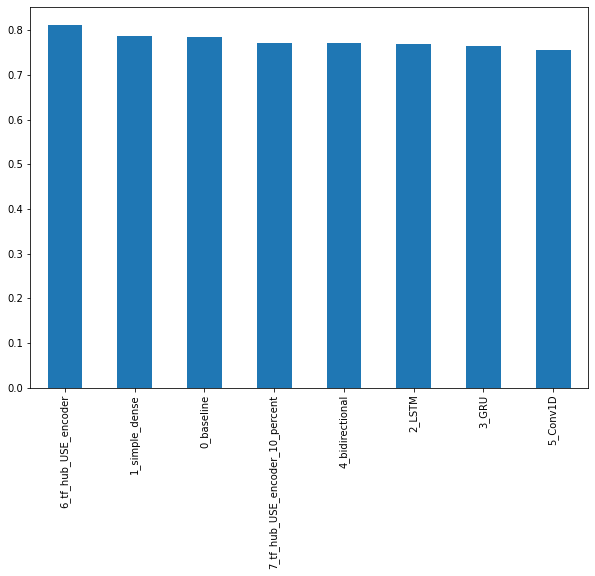

In [128]:
#Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7))

## Uploading our model training logs to TensorBoard.dev
We can further inspect our model's performance using TensorBoard dev: https://tensorboard.dev/

In [129]:
# view tensorboard logs of transfer learning modelling experiments
# upload tensorbaord dev records
!tensorboard dev upload --logdir ./model_logs/ \
  --name "NLP Modelling experiments" \
  --description "Comparing multiple different types of model architectures on Kaggle Tweets text classificaiton dataset" \
  --one_shot #exit the uploader once uploading is finishedyes
  


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=BHctnTEgJD1EDmQUil6QDWtguK2OmP&prompt=consent&access_type=offline

my modelling experiments are visible on TensorBoard dev: https://tensorboard.dev/experiment/W412YAkeTmavd4tnsoxPbA/

>**Resource:** TensorBoard is great for quickly tracking experiments but for larger scale experiment trakcing option, check out weigth & biases: https://wandb.ai/site

In [131]:
#see the previous TensorBoard
!tensorboard dev list

https://tensorboard.dev/experiment/W412YAkeTmavd4tnsoxPbA/
	Name                 NLP Modelling experiments
	Description          Comparing multiple different types of model architectures on Kaggle Tweets text classificaiton dataset
	Id                   W412YAkeTmavd4tnsoxPbA
	Created              2022-03-08 06:25:08 (6 minutes ago)
	Updated              2022-03-08 06:25:18 (6 minutes ago)
	Runs                 16
	Tags                 5
	Scalars              240
	Tensor bytes         0
	Binary object bytes  3804827
https://tensorboard.dev/experiment/sm9le5SzQOSXkovMBVBWWQ/
	Name                 Transfer learning experiments with 10 Food101 classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   sm9le5SzQOSXkovMBVBWWQ
	Created              2022-02-23 05:03:48
	Updated              2022-02-23 05:03:52
	Runs                 10
	Tags                 5
	Scalars              162
	Tensor bytes       

## Saving and loading a trained model

There are two main formats to save a model to in TensorFlow:
1. The HDF5 format
2. The 'SavedModel' format (this is the default when using TensorFlow)


In [133]:
# Save TF Hub sentence encoder model to HDF5 format
model_6.save("model_6.h5")

In [134]:
import tensorflow_hub as hub

In [135]:
#load model with custom Hub Layer (required HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [137]:
#how does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 25ms/step - loss: 0.4242 - accuracy: 0.8123


[0.424177885055542, 0.8123359680175781]

In [138]:
model_6_results

{'accuracy': 81.23359580052494,
 'f1': 0.8115900402999853,
 'precision': 0.8126207816553097,
 'recall': 0.8123359580052494}

Now let's save to the SavedModel format..

In [139]:
# save TF Hub sentence encoder model to SavedModel format
model_6.save("model_6_SavedModel_format")

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


In [140]:
#load in a model from SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [141]:
#evaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 3s 33ms/step - loss: 0.4242 - accuracy: 0.8123


[0.424177885055542, 0.8123359680175781]